In [16]:
import rasterio
#from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import os
#import re
#from sklearn.cluster import KMeans
#from scipy.ndimage import binary_dilation
#from matplotlib.colors import ListedColormap
#import matplotlib.colors as mcolors
from rasterio.errors import RasterioIOError
import csv
#from skimage import io
#from pyproj import Transformer
#import requests
#from PIL import Image
import sys
#from io import BytesIO
if '/mnt/c/Users/attic/HLS Kelp Detection/tools' not in sys.path:
    sys.path.append('/mnt/c/Users/attic/HLS Kelp Detection/tools')
import kelp_tools_linux as kt
import data_tools as dt
import cupy as cp

In [17]:
tile = '10UCU'
location = 'Isla_vista_kelp'
cloud_cover_threshold = .25
save_mask = True
save_classification = True
path = '/mnt/c/Users/attic/HLS Kelp Detection/imagery/tiles'
#path = r'C:\Users\attic\HLS_Kelp\imagery\Isla_vista_kelp_2018\11SKU'
item = 'HLS.L30.T10UCU.2017257T190743.v2.0'
save_to = '/mnt/c/Users/attic/HLS Kelp Detection/random_forest/training_data/unclassified'
show_dem = True
use_kmeans = False

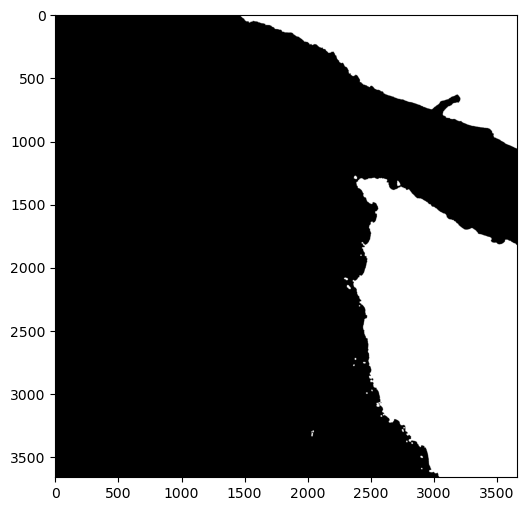

In [18]:
tile_path = os.path.join(path,tile)
img_path = os.path.join(path,tile, item)

dem_path = os.path.join(path,tile,'dem')
img_files = kt.filter_and_sort_files(img_path,item)

geotiff_path = os.path.join(img_path, img_files[0])

land_mask = kt.create_land_mask(hls_path=geotiff_path, dem_path=dem_path, show_image=show_dem, as_numpy=True)

2017-09-14T19:07:43.2338990Z
['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSL30.020/HLS.L30.T10UCU.2017257T190743.v2.0/HLS.L30.T10UCU.2017257T190743.v2.0.jpg']


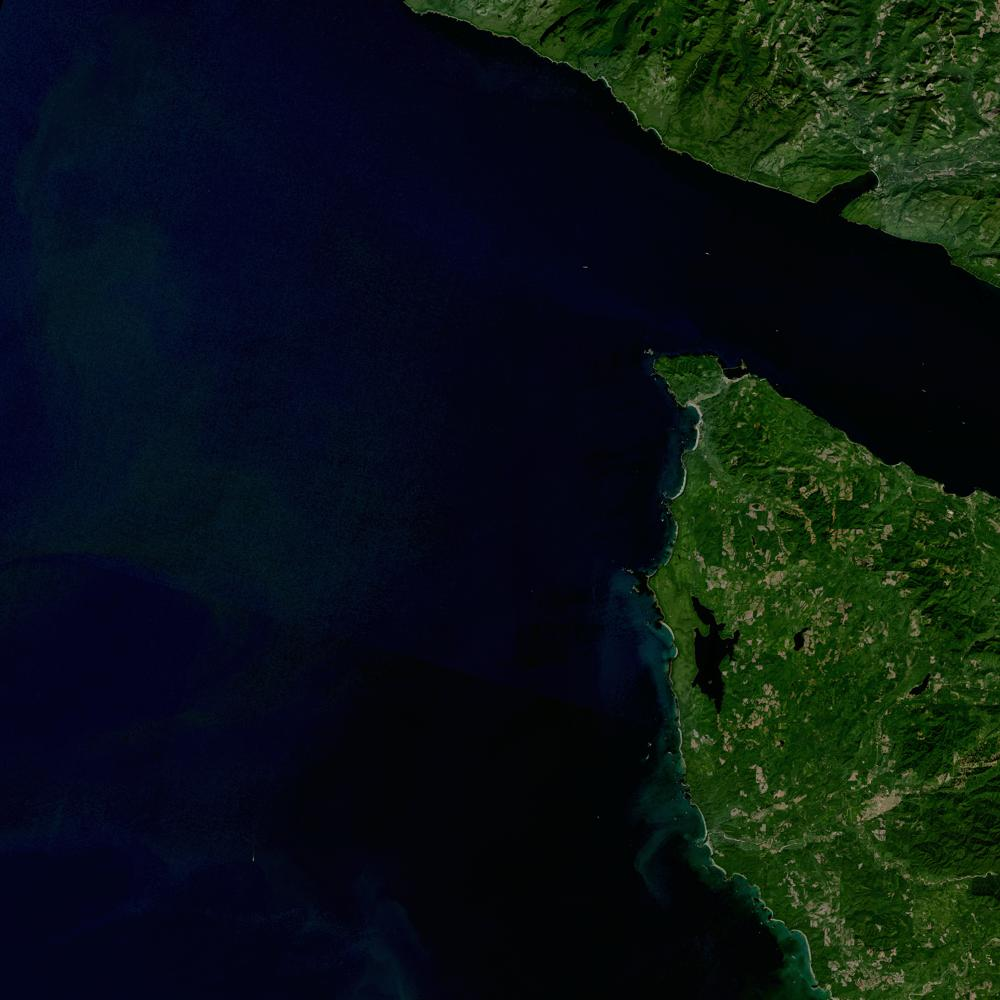

In [19]:
dt.view_img(img_path)

In [20]:
##==========Fmask Cloud mask==========##

cloud_land_mask, cloud_but_not_land_mask, percent_cloud_covered = kt.create_qa_mask(land_mask, img_path=img_path, as_numpy=True)

##==========Create stacked np array, Apply landmask==========##
img_bands = []
crs = None
transform = None
try:
    for file in img_files:
        with rasterio.open(os.path.join(img_path, file)) as src:
            img_bands.append(np.where(land_mask, 0, np.asarray(src.read(1))))
            if(transform is None):
                transform = src.transform
                crs= src.crs
except RasterioIOError as e:
    print(f"Error reading file {file} in granule {item}: {e}")
    sys.exit()

img = np.stack(img_bands, axis=0)
n_bands, height, width = img.shape
img_normalized = kt.normalize_img(img,flatten=True, as_numpy=True)

/mnt/c/Users/attic/HLS Kelp Detection/tools/kelp_tools_linux.py:302: RuntimeWarning: invalid value encountered in cast
  img_2D_nor = (img_2D_nor * 255).astype(np.uint8)


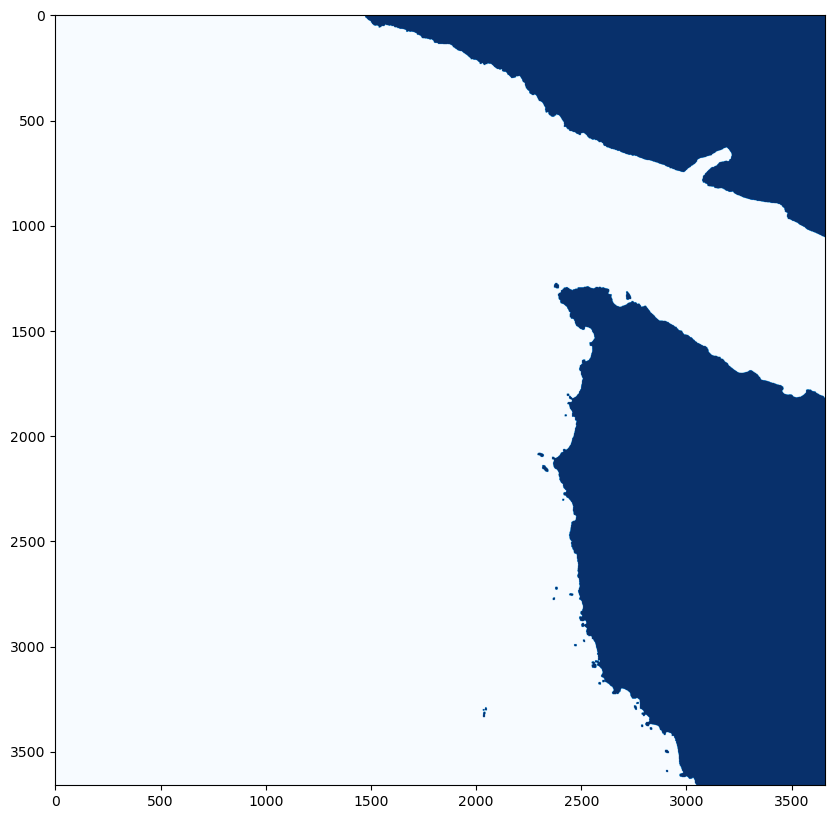

In [21]:
cloud_but_not_land_mask= np.array(cloud_but_not_land_mask)
land_mask = np.array(land_mask)
ocean_mask = (~land_mask & ~cloud_but_not_land_mask)
#cloud_but_not_land_mask #This is a reminder to use this pre-made mask 


combined_mask = np.full(ocean_mask.shape, 1)
combined_mask[land_mask] = 3
combined_mask[cloud_but_not_land_mask] = 1
combined_mask[ocean_mask] = 1

plt.figure(figsize=(20, 10))
plt.imshow(np.array(combined_mask), cmap='Blues')
plt.show()

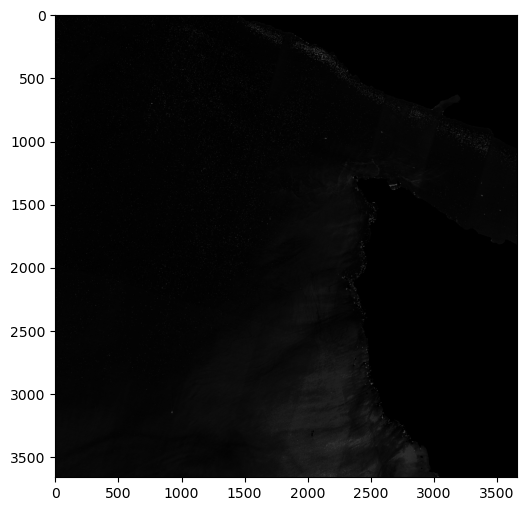

In [22]:
if save_classification:
    if not os.path.isdir (save_to):
        os.mkdir(save_to)
    classification_path = os.path.join(save_to,f'{item}_unclassified.tif') 
    height, width = combined_mask.shape
    reshaped_normalized_img = np.array(img_normalized)
    combined_img = np.dstack((reshaped_normalized_img,combined_mask))

    plt.figure(figsize=(6, 6))
    plt.imshow(combined_img[:,:,4], cmap='gray')
    plt.show()  

    num_bands = 7
    data_type = rasterio.uint8
    profile = {
        'driver': 'GTiff',
        'width': width,
        'height': height,
        'count': 7,  # one band
        'dtype': data_type,  # assuming binary mask, adjust dtype if needed
        'crs': crs,
        'transform': transform,
        'nodata': 0  # assuming no data is 0
    }
    # Write the land mask array to GeoTIFF
    with rasterio.open(classification_path, 'w', **profile) as dst:
        for i in range(num_bands):
            dst.write(combined_img[:,:,i].astype(data_type), i + 1)